# Part B

In [2]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

2022-10-10 22:04:00.500975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 22:04:00.501019: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [4]:
import pandas as pd
df = pd.read_csv('./data/hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [5]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [6]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## a) Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using entries from year 2020 and before as training data (with the remaining data from year 2021 and 2022 used as test data).

In [7]:
# droppping irrelevant data , drop 'year' & 'resale_price' later
df_cleaned = df.drop(['full_address','nearest_stn'],axis=1)

# Split data to train data (<=2020) and test data(> 2020)
train_dataframe = df_cleaned[df_cleaned.year<=2020]
val_dataframe = df_cleaned[df_cleaned.year > 2020]

# drop the remaining year data
train_dataframe = train_dataframe.drop(['year'],axis=1)
val_dataframe = val_dataframe.drop(['year'],axis=1)

### Why is this done instead of using random train/test splits?
Since the nature of the problem will always be using older data to predict future models, we simulate this by using older data to train and testing it on newer data

## b) A team of data scientists has implemented a linear regression model via Scikit-learn. They obtained a test R 2 value of 0.627 and happily shared with you that their model only took a few seconds to train. They suggest you to try out an equivalent deep learning model to see if you get a similar result. Recall that a linear regression model is equivalent to a neural network with only 1 Dense layer (i.e. no hidden layer) with linear activation and 1 output node.

## However, modelling such a mix of feature types with neural networks requires some changes to the input layer. Implement this neural network by following this tutorial from the Keras documentation which guides you through the process of using the Functional API to do so. After encoding / standardisation, the features should be concatenated. Your architecture should resemble the figure shown in Appendix A.

### converting dataframe into a dataset:

In [8]:
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

2022-10-10 22:04:16.195105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 22:04:16.195635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 22:04:16.195761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-10 22:04:16.195856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-10 22:04:16.199100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

### Building the model

# Discerning numerical and categorical features and their types

* numerical_features: ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality',
'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

* categorical_features: [ 'month', 'flat_model_type', 'storey_range']


In [9]:
#separating fields into numerical and categorical features

numerical_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality',
'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

categorical_features = [ 'month', 'flat_model_type', 'storey_range']

# visualising which categorical variable requires one-hot encoding
print("numerical_features\t:")
for feature in numerical_features:
    print("{} \t: {}".format(feature,train_dataframe[feature].dtype))
print()
print("categorical_features\t:")
for feature in categorical_features:
    print("{} \t: {}".format(feature,train_dataframe[feature].dtype))

numerical_features	:
dist_to_nearest_stn 	: float64
dist_to_dhoby 	: float64
degree_centrality 	: float64
eigenvector_centrality 	: float64
remaining_lease_years 	: float64
floor_area_sqm 	: float64

categorical_features	:
month 	: int64
flat_model_type 	: object
storey_range 	: object


# Building the input layer
***
## categorically:
1. encode month as integer
2. encode flat_model_type, storey_range as string

## numerically:

1. normalise as integers
***

In [9]:
def build_model():
    # Categorical features encoded as integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")

    # Categorical feature encoded to an integer
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

    # Numerical features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality =keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality=keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years=keras.Input(shape=(1,), name="remaining_lease_years")
    floor_area_sqm =keras.Input(shape=(1,), name="floor_area_sqm")
    
    all_inputs = [
        dist_to_nearest_stn,
        dist_to_dhoby,
        degree_centrality,
        eigenvector_centrality,
        remaining_lease_years,
        floor_area_sqm ,
        month,
        flat_model_type,
        storey_range
    ]
    
    # Integer categorical features
    month_encoded = encode_categorical_feature(month, "month", train_ds, False)

    # String categorical features
    flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
    storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

    # Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn,'dist_to_nearest_stn',train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby,'dist_to_dhoby',train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality,'degree_centrality',train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality,'eigenvector_centrality',train_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years,'remaining_lease_years',train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,'floor_area_sqm',train_ds)
    
    all_features = layers.concatenate([
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
        month_encoded,    
        flat_model_type_encoded,
        storey_range_encoded,
    ])
    
    return all_features,all_inputs

## c) The team suggests you to train the model for 50 epochs using mini-batch gradient descent with batch size = 256, Adam optimiser (with a default learning rate of 𝛼 = 0.001) and mean square error as cost function. However, you find that your results are far off from their model. Change the optimiser to SGD (with default learning rate of 𝛼 = 0.01) and observe how the problem gets fixed. Report the test R 2 value and explain why the change to SGD fixes the problem faced when using Adam optimiser. (Hint: Look carefully at how Adam is implemented and see how SGD is different.)

### modeling the linear regression model with Adam optimizer:

In [40]:
# build the rest of the layers
input_layer,all_inputs = build_model()
output = layers.Dense(1,activation='linear')(input_layer)
adam_model = keras.Model(all_inputs,output)
adam_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),metrics = [r2,'mean_squared_error'],loss='mean_squared_error')

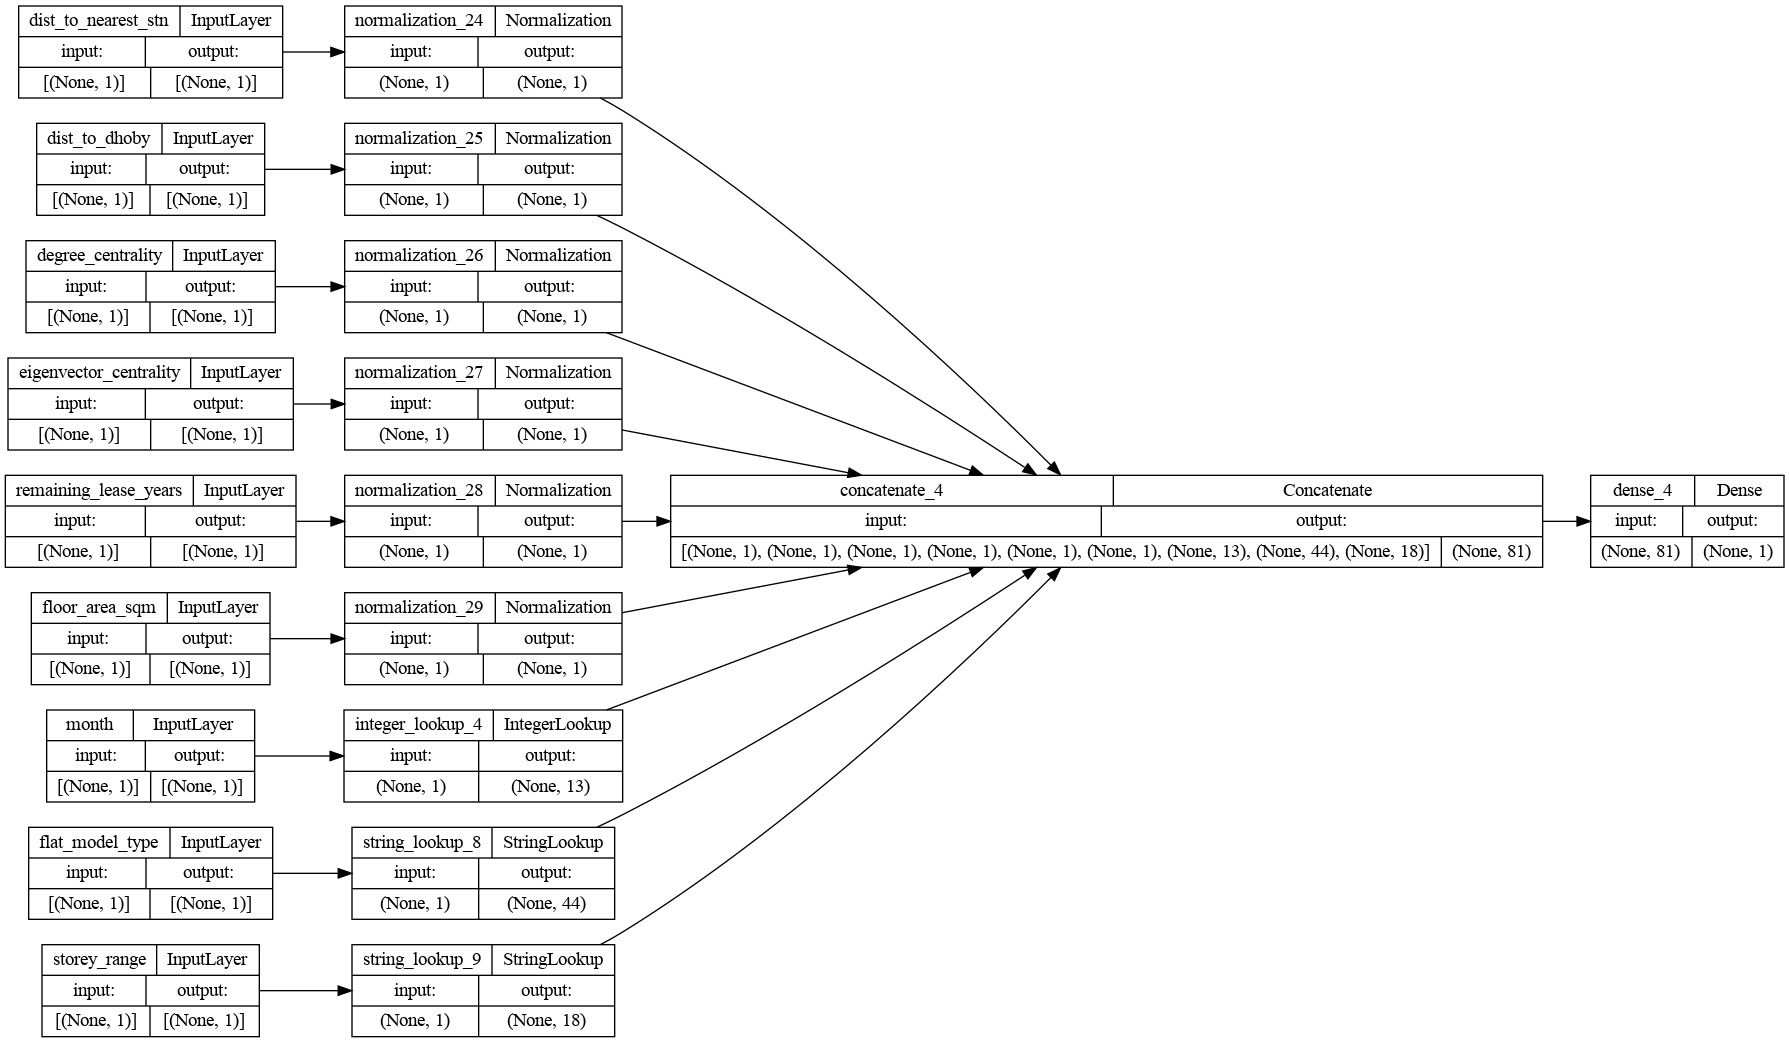

In [41]:
keras.utils.plot_model(adam_model,show_shapes=True,rankdir='LR')

### implementing some useful callback functions:

In [65]:
# a callback function to persist r2 values from each epoch

class storeInformationCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.store =[]
    
    def on_epoch_end(self,epoch,logs=None):
        self.store.append([epoch,logs])

In [66]:
# callback to save the entire model
def saveModelsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 0,
        save_best_only = True,
        save_weights_only = False,
        mode = mode,
        save_freq=save_freq,
)

In [68]:
adam_storage = storeInformationCallback()
adam_history = adam_model.fit(train_ds, 
                    epochs=50, 
                    validation_data=val_ds,
                    shuffle=True,
                    callbacks=[
                       adam_storage,
                       saveModelsCallback(
                           path='./data/models/partB_Q1/1c_Adam/best_model',
                           monitor = 'val_loss',
                           mode='min',
                           save_freq='epoch'
                       )])

Epoch 1/50
340/342 [============================>.] - ETA: 0s - loss: 219429945344.0000 - r2: -8.3431 - mean_squared_error: 219429945344.0000
Epoch 1: val_loss improved from inf to 301383221248.00000, saving model to ./data/models/partB_Q1/1c_Adam/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_Adam/best_model/assets
342/342 [==============================] - 4s 10ms/step - loss: 219498053632.0000 - r2: -8.3418 - mean_squared_error: 219498053632.0000 - val_loss: 301383221248.0000 - val_r2: -10.0646 - val_mean_squared_error: 301383221248.0000
Epoch 2/50
326/342 [===========================>..] - ETA: 0s - loss: 219514765312.0000 - r2: -8.3276 - mean_squared_error: 219514765312.0000
Epoch 2: val_loss improved from 301383221248.00000 to 301381582848.00000, saving model to ./data/models/partB_Q1/1c_Adam/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_Adam/best_model/assets
342/342 [==============================] - 3s 8ms/step - loss: 2194967

Epoch 15/50
340/342 [============================>.] - ETA: 0s - loss: 219461304320.0000 - r2: -8.3510 - mean_squared_error: 219461304320.0000
Epoch 15: val_loss improved from 301362675712.00000 to 301361201152.00000, saving model to ./data/models/partB_Q1/1c_Adam/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_Adam/best_model/assets
342/342 [==============================] - 3s 8ms/step - loss: 219479457792.0000 - r2: -8.3527 - mean_squared_error: 219479457792.0000 - val_loss: 301361201152.0000 - val_r2: -10.0688 - val_mean_squared_error: 301361201152.0000
Epoch 16/50
328/342 [===========================>..] - ETA: 0s - loss: 219738947584.0000 - r2: -8.3406 - mean_squared_error: 219738947584.0000
Epoch 16: val_loss improved from 301361201152.00000 to 301359595520.00000, saving model to ./data/models/partB_Q1/1c_Adam/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_Adam/best_model/assets
342/342 [==============================] - 4s 10ms/s

Epoch 29/50
326/342 [===========================>..] - ETA: 0s - loss: 219359657984.0000 - r2: -8.3194 - mean_squared_error: 219359657984.0000
Epoch 29: val_loss improved from 301340819456.00000 to 301339246592.00000, saving model to ./data/models/partB_Q1/1c_Adam/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_Adam/best_model/assets
342/342 [==============================] - 4s 10ms/step - loss: 219460812800.0000 - r2: -8.3342 - mean_squared_error: 219460812800.0000 - val_loss: 301339246592.0000 - val_r2: -10.0745 - val_mean_squared_error: 301339246592.0000
Epoch 30/50
338/342 [============================>.] - ETA: 0s - loss: 219517534208.0000 - r2: -8.3485 - mean_squared_error: 219517534208.0000
Epoch 30: val_loss improved from 301339246592.00000 to 301337772032.00000, saving model to ./data/models/partB_Q1/1c_Adam/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_Adam/best_model/assets
342/342 [==============================] - 3s 9ms/s

Epoch 43/50
336/342 [============================>.] - ETA: 0s - loss: 219447279616.0000 - r2: -8.3301 - mean_squared_error: 219447279616.0000
Epoch 43: val_loss improved from 301318701056.00000 to 301317292032.00000, saving model to ./data/models/partB_Q1/1c_Adam/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_Adam/best_model/assets
342/342 [==============================] - 4s 9ms/step - loss: 219442184192.0000 - r2: -8.3397 - mean_squared_error: 219442184192.0000 - val_loss: 301317292032.0000 - val_r2: -10.1078 - val_mean_squared_error: 301317292032.0000
Epoch 44/50
336/342 [============================>.] - ETA: 0s - loss: 219438989312.0000 - r2: -8.3531 - mean_squared_error: 219438989312.0000
Epoch 44: val_loss improved from 301317292032.00000 to 301315719168.00000, saving model to ./data/models/partB_Q1/1c_Adam/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_Adam/best_model/assets
342/342 [==============================] - 3s 8ms/st

In [70]:
# loading already trained_model withh best weights according to loss to avoid training everytime
best_adam_model = tf.keras.models.load_model('./data/models/partB_Q1/1c_Adam/best_model',custom_objects ={'r2':r2})

In [83]:
# getting the r2 of the last epoch
r2_last_epoch = adam_storage.store[-1][1]['val_r2']
print('r2 of Adam optimizer at last epoch: {}'.format(r2_last_epoch))

r2 of Adam optimizer at last epoch: -10.076010704040527


### Implementing model with SGD optimizer:

In [85]:
# build the rest of the layers
input_layer,all_inputs = build_model()
output = layers.Dense(1,activation='linear')(input_layer)
sgd_model = keras.Model(all_inputs,output)
sgd_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),metrics = [r2,'mean_squared_error'],loss='mean_squared_error')

In [86]:
sgd_storage = storeInformationCallback()
sgd_history = sgd_model.fit(train_ds, 
                    epochs=50, 
                    validation_data=val_ds,
                    shuffle=True,
                    callbacks=[
                       sgd_storage,
                       saveModelsCallback(
                           path='./data/models/partB_Q1/1c_SGD/best_model',
                           monitor = 'val_loss',
                           mode='min',
                           save_freq='epoch'
                       )])

Epoch 1/50
328/342 [===========================>..] - ETA: 0s - loss: 19274440704.0000 - r2: 0.1828 - mean_squared_error: 19274440704.0000
Epoch 1: val_loss improved from inf to 13719157760.00000, saving model to ./data/models/partB_Q1/1c_SGD/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_SGD/best_model/assets
342/342 [==============================] - 4s 9ms/step - loss: 18745757696.0000 - r2: 0.2062 - mean_squared_error: 18745757696.0000 - val_loss: 13719157760.0000 - val_r2: 0.4987 - val_mean_squared_error: 13719157760.0000
Epoch 2/50
330/342 [===========================>..] - ETA: 0s - loss: 5475767296.0000 - r2: 0.7680 - mean_squared_error: 5475767296.0000
Epoch 2: val_loss improved from 13719157760.00000 to 12654178304.00000, saving model to ./data/models/partB_Q1/1c_SGD/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_SGD/best_model/assets
342/342 [==============================] - 3s 8ms/step - loss: 5472724992.0000 - r2: 0.7687 -

Epoch 16/50
339/342 [============================>.] - ETA: 0s - loss: 3997819648.0000 - r2: 0.8305 - mean_squared_error: 3997819648.0000
Epoch 16: val_loss did not improve from 11179563008.00000
342/342 [==============================] - 2s 5ms/step - loss: 3997021184.0000 - r2: 0.8307 - mean_squared_error: 3997021184.0000 - val_loss: 11221808128.0000 - val_r2: 0.5893 - val_mean_squared_error: 11221808128.0000
Epoch 17/50
335/342 [============================>.] - ETA: 0s - loss: 3970919424.0000 - r2: 0.8317 - mean_squared_error: 3970919424.0000
Epoch 17: val_loss improved from 11179563008.00000 to 11098267648.00000, saving model to ./data/models/partB_Q1/1c_SGD/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1c_SGD/best_model/assets
342/342 [==============================] - 3s 7ms/step - loss: 3977129216.0000 - r2: 0.8312 - mean_squared_error: 3977129216.0000 - val_loss: 11098267648.0000 - val_r2: 0.5932 - val_mean_squared_error: 11098267648.0000
Epoch 18/50
330

In [87]:
# loading already trained_model withh best weights according to loss
best_sgd_model = tf.keras.models.load_model('./data/models/partB_Q1/1c_SGD/best_model',custom_objects ={'r2':r2})

## finding r2 of sgd model

In [91]:
# getting the r2 of the last epoch
r2_last_epoch = sgd_storage.store[-1][1]['val_r2']
print('r2 of SGD optimizer at last epoch: {}'.format(r2_last_epoch))

r2 of SGD optimizer at last epoch: 0.6067984700202942


### Why does the change to sgd fix the r2 problem?

The r2 values for the test dataset is negative, which signifies that the model does not behave according to the trend of the data.Adam optimizer sets different learning rates for each parameter by using a combination of Root Mean Square Propagation and Adaptpive Gradient Algorithm. This allows Adam to increase or decrease learning rates adaptively.In turn, this results in a ununiform scaling of the gradients which leads to poor performance on testing data due to poor generalisation
In Contrast, SGD has a uniform scaling of the gradients with a uniform learning rate, which may take longer to converge but has better generalisation on test data.
Thus, r2 value of SGD is much better than that of Adam

## d) Add 1 hidden layer (10 units) to the architecture in Q1c and train it with the same configuration as in Q1c (i.e. with Adam) except that the learning rate is increased to 0.08. Report the test R 2 value.

In [92]:
input_layer,all_inputs = build_model()
hidden_layer = layers.Dense(10,activation='relu')(input_layer)
output_layer = layers.Dense(1,activation='linear')(hidden_layer)
new_model = keras.Model(all_inputs,output_layer)

new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.08),
                  metrics = [r2,'mean_squared_error'],
                  loss='mean_squared_error')

In [93]:
# storage callback to persist logs information
new_storage = storeInformationCallback()

new_history = new_model.fit(train_ds, 
                    epochs=50, 
                    validation_data=val_ds,
                    shuffle=True,
                    callbacks=[
                       new_storage,
                       saveModelsCallback(
                           path='./data/models/partB_Q1/1d/best_model',
                           monitor = 'val_loss',
                           mode='min',
                           save_freq='epoch'
                       )])

Epoch 1/50
341/342 [============================>.] - ETA: 0s - loss: 202890756096.0000 - r2: -7.6360 - mean_squared_error: 202890756096.0000
Epoch 1: val_loss improved from inf to 237627686912.00000, saving model to ./data/models/partB_Q1/1d/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1d/best_model/assets
342/342 [==============================] - 5s 11ms/step - loss: 202852237312.0000 - r2: -7.6271 - mean_squared_error: 202852237312.0000 - val_loss: 237627686912.0000 - val_r2: -7.7348 - val_mean_squared_error: 237627686912.0000
Epoch 2/50
334/342 [============================>.] - ETA: 0s - loss: 111201206272.0000 - r2: -3.7225 - mean_squared_error: 111201206272.0000
Epoch 2: val_loss improved from 237627686912.00000 to 101369044992.00000, saving model to ./data/models/partB_Q1/1d/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1d/best_model/assets
342/342 [==============================] - 4s 9ms/step - loss: 110034378752.0000 - r2: -3.6

342/342 [==============================] - 3s 9ms/step - loss: 3699763456.0000 - r2: 0.8428 - mean_squared_error: 3699763456.0000 - val_loss: 10672670720.0000 - val_r2: 0.6086 - val_mean_squared_error: 10672670720.0000
Epoch 16/50
330/342 [===========================>..] - ETA: 0s - loss: 3624336640.0000 - r2: 0.8458 - mean_squared_error: 3624336640.0000
Epoch 16: val_loss improved from 10672670720.00000 to 10599010304.00000, saving model to ./data/models/partB_Q1/1d/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1d/best_model/assets
342/342 [==============================] - 4s 11ms/step - loss: 3624551424.0000 - r2: 0.8459 - mean_squared_error: 3624551424.0000 - val_loss: 10599010304.0000 - val_r2: 0.6114 - val_mean_squared_error: 10599010304.0000
Epoch 17/50
331/342 [============================>.] - ETA: 0s - loss: 3545344256.0000 - r2: 0.8496 - mean_squared_error: 3545344256.0000
Epoch 17: val_loss improved from 10599010304.00000 to 10369893376.00000, saving 

Epoch 32/50
339/342 [============================>.] - ETA: 0s - loss: 2775883520.0000 - r2: 0.8817 - mean_squared_error: 2775883520.0000
Epoch 32: val_loss improved from 9523210240.00000 to 9450202112.00000, saving model to ./data/models/partB_Q1/1d/best_model
INFO:tensorflow:Assets written to: ./data/models/partB_Q1/1d/best_model/assets
342/342 [==============================] - 3s 8ms/step - loss: 2774508032.0000 - r2: 0.8817 - mean_squared_error: 2774508032.0000 - val_loss: 9450202112.0000 - val_r2: 0.6534 - val_mean_squared_error: 9450202112.0000
Epoch 33/50
336/342 [============================>.] - ETA: 0s - loss: 2763619072.0000 - r2: 0.8824 - mean_squared_error: 2763619072.0000
Epoch 33: val_loss did not improve from 9450202112.00000
342/342 [==============================] - 2s 5ms/step - loss: 2762875392.0000 - r2: 0.8824 - mean_squared_error: 2762875392.0000 - val_loss: 9642422272.0000 - val_r2: 0.6452 - val_mean_squared_error: 9642422272.0000
Epoch 34/50
339/342 [=========

342/342 [==============================] - 2s 5ms/step - loss: 2679564800.0000 - r2: 0.8858 - mean_squared_error: 2679564800.0000 - val_loss: 9444484096.0000 - val_r2: 0.6538 - val_mean_squared_error: 9444484096.0000


## r2 of sgd model + 1 extra hidden layer:

In [95]:
# getting the r2 of the last epoch
r2_last_epoch = new_storage.store[-1][1]['val_r2']
print('r2 at last epoch: {}'.format(r2_last_epoch))

r2 at last epoch: 0.6538474559783936


## e) Compare the performance of the linear regression model to the Dense layer (Q1c) and the NN architecture (Q1d) and suggest reasons for the observations you made.

* Linear Regression Model r2 (scientists): 0.627
* r2 with SGD (1c): 0.607
* NN architecture(1d): 0.654

The model with the Dense layer(1c)  performed around the same as the linear Regressiong model. This is because these 2 models are essentially the same. The difference in r2 might be just due to the Linear regression Model fitting better by chance.
The model with the NN architecture(1d) performed the best out of the 3 models, this is because a NN architecture can better capture the non-linearity between features in the dataset.